Recurrent Neural Networks (RNN)
====================

In this exercise we will work with Recurrent Neural Networks (RNN). A RNN is class of neural networks where the output not only depends on the current input but also on previous inputs along a given input sequence. This allows to exhibit temporal dynamic behaviour and contextual information in a sequence. Common applications for RNN are:

- time series analysis
- speech recognition
- machine translation
- image captioning


Goal of this exercise
========

This exercise notebook should help you to experiment how recurrent neural networks are implemented, trained, and used for computer vision problems. Therefore, this notebook is structured as follows:
1. Implement your own simple RNN class in Pytorch.
2. Explore the backpropagation of the gradients in the RNN and discuss the vanishing gradient problem.
3. Implement your own LSTM (Long-Short Term Memory) Network and show that this architecture improves the vanishing gradient problem.
4. Build a RNN classifier for the MNIST dataset and train your model.
5. Tune the hyperparameters of your model and submit your best model to the server to get bonus points.



In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
import os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
x = torch.randn((1, 1, 32, 32))
x.to(device)
x = torch.autograd.Variable(x)
del x
torch.cuda.empty_cache()

In [4]:
import platform
print('Using python: ', platform.python_version())
print('Using torch version: ', torch.__version__)
print('Using device: ', device)

Using python:  3.7.3
Using torch version:  1.1.0
Using device:  cuda:0


## Simple Recurrent Neural Network

The recurrent loops in a RNN allow relevant information to persist over time. A simple RNN architecture is shown here:
<img src=http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-rolled.png width="150">

A simple RNN takes not only an input X at time step t but also passes a hidden state that is the output of the previous time step into the network. The output of a RNN cell at time step t reads in Eq. 1:

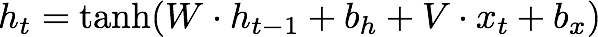

In this task you have to implement a simple one-layer RNN as a class in Pytorch, where you can choose a relu or tanh activation in the cell.You can see the architecture of a simple RNN in the figure below.


<img src=http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-SimpleRNN.png width="600">



Luckily, Pytorch already has implemented a simple RNN in their library and you can call the RNN with <code>nn.RNN</code>. We will use the Pytorch RNN function to check if we have built the correct cell and compare the output of both functions. We also compare the running time of both classes.

In [5]:
# ToDo: Implement the RNN class
from exercise_code.rnn.rnn_nn import RNN
import torch.nn as nn
import timeit

# choose your network parameters
input_size=3
hidden_dim=3
seq_len= 10 

# define the two models
pytorch_rnn=nn.RNN(input_size, hidden_dim)
i2dl_rnn=RNN(input_size, hidden_dim)

# initialise both rnn with same values
for p in pytorch_rnn.parameters():
    nn.init.constant_(p, val=0.3)
for p in i2dl_rnn.parameters():
    nn.init.constant_(p, val=0.3)
    
X=torch.randn(seq_len, 5, input_size)
h = torch.randn(1, 5, hidden_dim)

output_pytorch, h_pytorch = pytorch_rnn(X,h)
output_i2dl, h_i2dl = i2dl_rnn(X,h)

# The difference of outputs should be 0!!

diff = torch.sum((output_pytorch-output_i2dl)**2)
print("Differnce between pytorch and your RNN implementation: %s" %diff.item())
if diff.item()<10**-10:
    print("Cool, you implemented a correct model.")
else:
    print("Upps! There is something wrong in your model. Try again!")

Differnce between pytorch and your RNN implementation: 0.0
Cool, you implemented a correct model.


In [6]:
import timeit
runs=10**4

print("Time Pytorch RNN {} runs: {:.3f}s".format(runs, timeit.timeit("pytorch_rnn(X)", 
                                       setup="from __main__ import pytorch_rnn, X", 
                                       number=runs))
     )

print("Time I2DL RNN {} run: {:.3f}s".format(runs, timeit.timeit("i2dl_rnn(X)", 
                                       setup="from __main__ import i2dl_rnn, X", 
                                       number=runs))
     )

Time Pytorch RNN 10000 runs: 7.075s
Time I2DL RNN 10000 run: 9.003s


From now on we will use the Pytorch module that is faster and optimised in performance. However, it is always a good exercise to build the functions by yourself and we really advice you to do the exercise!

## Vanishing Gradient

As discussed in the lecture, the simple RNN suffers from vanishing gradients in the backpropagation. The hidden state is manipulated in every time step along the sequence and the effect of the past inputs to the final output vanishes with the distance in time. In the next cell we will explore the vanishing effect of previous inputs in the RNN.

In [7]:
############################################################################
# TODO: Define a RNN and explore the gradients on the output h_T wrt. the  #
# input at time t and plot your result. What behaviour do you observe?     #
# Hints:                                                                   #
#   - use one input feature                                                #
#   - pytorch allows backward() pass wrt. to any vector                    #
#   - backward() can only be applied to scalars and not to output tensors  #
#   - choose a good representation of the gradient plot                    #
############################################################################
pass
############################################################################
#                             END OF YOUR CODE                             #
############################################################################


<div class="alert alert-info">
    <h3>Note</h3>
    <p>It can be seen that the gradient of the of the output at time t wrt. to a previous input decreases exponentially. Hence, the final output does not change significantly for changes in the previous input and hence the RNN does not have memory.</p> 
<h3>Question</h3> 
<p>In order to better understand the vanishing gradient problem, calculate the gradients 
dh_t/dV, dh_t /dW, and dh_t/dX_0 analytically for t=3 and h_0=0 using Eq. 1. This exercise might seem a little bit tedious but it is really useful. Can you explain the vanishing gradient mathematically based on your findings?</p>
</div>

## Long-Short Term Memory Network (LSTM)
The vanishing gradient problem had been known for some time until Schmidhuber (1997) developed the Long-Short Term Memory Network and showed that this architecture can overcome the problem. <br> 
A LSTM is a more advanced recurrent network architecture that is able to learn long time dependencies. The architecture of a LSTM is composed of a forget, input, and output gate and the cell can remember values over arbitrary time intervals. Despite various different and exotic LSTM architectures, the standard LSTM cell is shwon in the figure below:


<img src=http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png width="600">



Compared to a simple RNN the LSTM cell has a hidden vector and an additional cell state vector. __What size does the cell state have?__ <br>
The operations inside the LSTM are given as 

<img src=https://wikimedia.org/api/rest_v1/media/math/render/svg/2db2cba6a0d878e13932fa27ce6f3fb71ad99cf1  width="600">
where 
f_t: forget gate,  <br>
i_t: input gate, <br>
o_t: output gate, <br>
h_t: hidden state vector, <br>
c_t: cell state vector, <br>
x_t: input vector, <br>
t is time step, 
<br> 
<br> 
and<br> 
sigma_g: sigmoid activation <br> 
sigma_c and sigma_h: hyperbolic tangent function


In the next step you should implement your own LSTM with the operations stated above.

In [8]:
# ToDo: Implement the RNN class
from exercise_code.rnn.rnn_nn import LSTM

# choose your input parameters
input_size=3
hidden_dim=3
seq_len= 10 

# define the two models
pytorch_lstm=nn.LSTM(input_size, hidden_dim)
i2dl_lstm=LSTM(input_size, hidden_dim)

# initialise both lstms with same values
for p in pytorch_lstm.parameters():
    nn.init.constant_(p, val=0.3)
for p in i2dl_lstm.parameters():
    nn.init.constant_(p, val=0.3)
    
X=torch.randn(seq_len, 1, input_size)

output_pytorch, (h_pytorch, _) = pytorch_lstm(X)
output_i2dl , (h_i2dl, _ )= i2dl_lstm(X)

# The difference of outputs should be 0!!
diff = torch.sum((output_pytorch-output_i2dl)**2)
print("Differnce between pytorch and your RNN implementation: %s" %diff.item())
if diff.item()<10**-10:
    print("Cool, you implemented a correct model.")
else:
    print("Upps! There is something wrong in your model. Try again!")

Differnce between pytorch and your RNN implementation: 0.0
Cool, you implemented a correct model.


In [9]:
import timeit
runs=10**4

print("Time Pytorch LSTM {} runs: {:.3f}s".format(runs, timeit.timeit("pytorch_lstm(X)", 
                                       setup="from __main__ import pytorch_lstm, X", 
                                       number=runs))
     )

print("Time I2DL LSTM {} run: {:.3f}s".format(runs, timeit.timeit("i2dl_lstm(X)", 
                                       setup="from __main__ import i2dl_lstm, X", 
                                       number=runs))
     )

Time Pytorch LSTM 10000 runs: 14.771s
Time I2DL LSTM 10000 run: 37.825s


## Explore Gradients 
Analogously to the RNN, calculate the gradients of the input wrt. to the output of the LSTM and compare it against the RNN gradients. __What do you see?__


In [10]:
############################################################################
# TODO: Define a RNN and LSTM and explore the gradients on the output h_T   #
# wrt. the input at time t and plot your result.                           #
############################################################################
pass
############################################################################
#                             END OF YOUR CODE                             #
############################################################################

## MNIST image classification with RNNs

In the previous exercises we already have classified images with a Fully Connected and Convolutional Network. In this exercise, we will solve the problem of image classification with a recurrent neural network.  

For the experiment we use the MNIST handwritten digits dataset which we already know from the autoencoder exercise. This dataset consists of images of the 10 different digits (10 classes). The images have the resolution 28 x 28. The idea for the RNN classifier is to interpret the image as a sequence of rows. This means that we pass the rows through the RNN and use the final hidden state for classification. 


<div class="alert alert-info">
    <h3>Note</h3>
    <p>
    In this semester you have seen three different types of neural networks, namely Multi-Layer Perceptrons (MLPs), Convolutional Neural Networks (CNNs), and now Recurrent Neural Networks (RNNs). We have seen that we can use all three architectures for image classification. However, it turned out that some models are better than others for image classification. Try to think about advantages and disadvantages of the models, regarding # of parameters, transformations of the object in the image (scaling, rotation, translation,...), training time, testing time, over-fitting, etc.

In [11]:
# Define data loader
from torchvision import transforms
import pickle

class Unsqueeze(object):
    """Adds a channel dimension that that our 2 dimensional input (H, W), 
    fits the 3 dimensional (H, W, C) expectations of pytorch's ToTensor function which
    expects a PIL image. This is very inefficient but you most probably will use pytorch's
    PIL image loader. Check out the documentation and make it more efficient :)
    """
    def __init__(self, dimension=0):
        self.dimension = dimension
    def __call__(self, numpy_array):
        extended_array = np.expand_dims(numpy_array, self.dimension)
        return extended_array
    def __repr__(self):
        return self.__class__.__name__ + 'dimension={}'.format(dimension)

    
# transformation of data
transform = transforms.Compose([
    Unsqueeze(dimension=3),     
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])


class MnistDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, 
                 transform=None):
        super(MnistDataset, self).__init__()
        self.images = images
        self.labels = labels
        self.transform = transform
       
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform: 
            image = self.transform(image)
        return image, label

    
# loading the train data
with open("datasets/mnist_train.p", "rb") as f:
    mnist_raw = pickle.load(f)

X, y= mnist_raw
############################################################################
# TODO: Set a useful training/ validation split                            #
############################################################################    

train_split = 0.8

############################################################################
#                             END OF YOUR CODE                             #
############################################################################


train_dset=MnistDataset(X[:int(len(X)*train_split)], y[:int(len(X)*train_split)], transform=transform)
val_dset=MnistDataset(X[int(len(X)*train_split):], y[int(len(X)*train_split):], transform=transform)


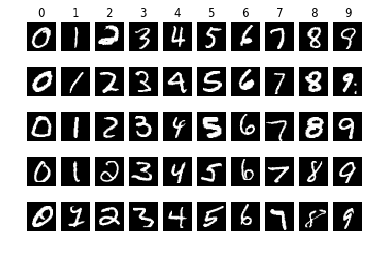

In [12]:
# Visualize some examples from the dataset. Stolen from other notebooks
# We show a few examples of training images from each class.
X=train_dset.images
y=train_dset.labels


classes = list(range(10))
num_classes = len(classes)
samples_per_class = 5
for y_hat, cls in enumerate(classes):
    idxs = np.flatnonzero(train_dset.labels == y_hat)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y_hat + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X[idx])
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

Build a classifier based on a RNN where you sequentially feed the rows in the network and use the final hidden state for prediction.

<img src=https://cdn-images-1.medium.com/max/800/1*Cm_c-I02rBa1rtLZXBhNUw.png width="600">


In [37]:
from exercise_code.rnn.rnn_nn import RNN_Classifier
from exercise_code.rnn.solver import Solver
model_rnn = RNN_Classifier()
batch_size = 32
train_loader = torch.utils.data.DataLoader(
                 dataset=train_dset,
                 batch_size=batch_size,
                 shuffle=True)
val_loader = torch.utils.data.DataLoader(
                dataset=val_dset,
                batch_size=batch_size,
                shuffle=False)

solver = Solver(optim_args={"lr": 1e-3})

# train rnn model
solver.train(model_rnn, train_loader, val_loader, log_nth=1000, num_epochs=10)

START TRAIN.


C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  


[Iteration 1000/15000] TRAIN loss: 0.123
[Epoch 1/10] TRAIN acc/loss: 0.875/0.123
[Epoch 1/10] VAL   acc/loss: 0.962/0.154
[Iteration 2500/15000] TRAIN loss: 0.114
[Epoch 2/10] TRAIN acc/loss: 1.000/0.114
[Epoch 2/10] VAL   acc/loss: 0.963/0.139
[Iteration 4000/15000] TRAIN loss: 0.118
[Epoch 3/10] TRAIN acc/loss: 0.969/0.118
[Epoch 3/10] VAL   acc/loss: 0.968/0.111
[Iteration 5500/15000] TRAIN loss: 0.105
[Epoch 4/10] TRAIN acc/loss: 1.000/0.105
[Epoch 4/10] VAL   acc/loss: 0.930/0.274
[Iteration 7000/15000] TRAIN loss: 0.102
[Epoch 5/10] TRAIN acc/loss: 0.938/0.102
[Epoch 5/10] VAL   acc/loss: 0.969/0.117
[Iteration 8500/15000] TRAIN loss: 0.097
[Epoch 6/10] TRAIN acc/loss: 1.000/0.097
[Epoch 6/10] VAL   acc/loss: 0.963/0.132
[Iteration 10000/15000] TRAIN loss: 0.104
[Epoch 7/10] TRAIN acc/loss: 1.000/0.104
[Epoch 7/10] VAL   acc/loss: 0.972/0.103
[Iteration 11500/15000] TRAIN loss: 0.090
[Epoch 8/10] TRAIN acc/loss: 0.938/0.090
[Epoch 8/10] VAL   acc/loss: 0.974/0.101
[Iteration 130

Train your RNN classifier and try to tune the hyperparameters. With your simple RNN classifier you should exceed an accuracy higher than __90%__.

Try to improve your model by using a LSTM.

In [91]:
from exercise_code.rnn.rnn_nn import LSTM_Classifier
model = LSTM_Classifier(hidden_size=512, num_layers=3)
batch_size = 128
train_loader = torch.utils.data.DataLoader(
                 dataset=train_dset,
                 batch_size=batch_size,
                 shuffle=True)
val_loader = torch.utils.data.DataLoader(
                dataset=val_dset,
                batch_size=batch_size,
                shuffle=False)

solver = Solver(optim_args={"lr": 1e-3})

# train lstm model
solver.train(model, train_loader, val_loader, log_nth=1000, num_epochs=30)

START TRAIN.


C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  


[Epoch 1/30] TRAIN acc/loss: 0.930/0.000
[Epoch 1/30] VAL   acc/loss: 0.956/0.146
[Epoch 2/30] TRAIN acc/loss: 0.977/0.000
[Epoch 2/30] VAL   acc/loss: 0.965/0.115
[Epoch 3/30] TRAIN acc/loss: 0.984/0.000
[Epoch 3/30] VAL   acc/loss: 0.976/0.077
[Epoch 4/30] TRAIN acc/loss: 0.961/0.000
[Epoch 4/30] VAL   acc/loss: 0.986/0.053
[Epoch 5/30] TRAIN acc/loss: 0.984/0.000
[Epoch 5/30] VAL   acc/loss: 0.982/0.060
[Epoch 6/30] TRAIN acc/loss: 0.984/0.000
[Epoch 6/30] VAL   acc/loss: 0.985/0.051
[Epoch 7/30] TRAIN acc/loss: 0.969/0.000
[Epoch 7/30] VAL   acc/loss: 0.982/0.062
[Epoch 8/30] TRAIN acc/loss: 0.969/0.000
[Epoch 8/30] VAL   acc/loss: 0.982/0.062
[Epoch 9/30] TRAIN acc/loss: 0.992/0.000
[Epoch 9/30] VAL   acc/loss: 0.986/0.046
[Epoch 10/30] TRAIN acc/loss: 0.977/0.000
[Epoch 10/30] VAL   acc/loss: 0.984/0.054
[Epoch 11/30] TRAIN acc/loss: 0.984/0.000
[Epoch 11/30] VAL   acc/loss: 0.988/0.044
[Epoch 12/30] TRAIN acc/loss: 0.992/0.000
[Epoch 12/30] VAL   acc/loss: 0.986/0.047
[Epoch 13/

In [96]:
solver.train(model, train_loader, val_loader, log_nth=1000, num_epochs=5)

START TRAIN.


C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  


[Epoch 1/5] TRAIN acc/loss: 1.000/0.000
[Epoch 1/5] VAL   acc/loss: 0.989/0.048
[Epoch 2/5] TRAIN acc/loss: 1.000/0.000
[Epoch 2/5] VAL   acc/loss: 0.990/0.051
[Epoch 3/5] TRAIN acc/loss: 1.000/0.000
[Epoch 3/5] VAL   acc/loss: 0.989/0.045
[Epoch 4/5] TRAIN acc/loss: 1.000/0.000
[Epoch 4/5] VAL   acc/loss: 0.991/0.040
[Epoch 5/5] TRAIN acc/loss: 0.992/0.000
[Epoch 5/5] VAL   acc/loss: 0.990/0.047
FINISH.


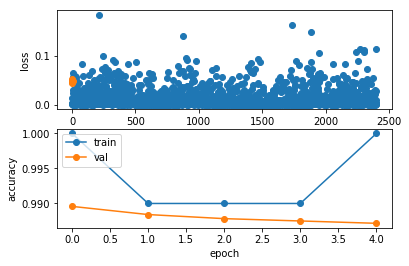

In [75]:
plt.subplot(2, 1, 1)
plt.plot(solver.train_loss_history, 'o')
plt.plot(solver.val_loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(solver.train_acc_history, '-o')
plt.plot(solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

Train your LSTM model again and see wether it improves performance on the validation set

# Test your Model
When you are satisfied with your training, you can save the model. In order to be eligible for the bonus points you have to achieve a score higher than __97__.

## Save the Model

When you are satisfied with your training, you can save the model.

In [95]:
model.save("models/rnn_mnist_nn.model")

Saving model... models/rnn_mnist_nn.model
